# UD2.2 Problem 2

### Student: Fernando Soto

Alice sends to Bob two classical bits by sending him only one qubit.

## Solution

Alice can transmit two classical bits to Bob by sending only one qubit, provided they share an entangled pair beforehand. If Alice and Bob share an entangled state (specifically a Bell pair), Alice can encode two bits of information into her half of the entangled pair by applying one of four unitary operations before sending it to Bob. Bob, upon receiving Alice’s qubit, performs a joint measurement on both qubits in the Bell basis. This measurement distinguishes the four possible states, thus recovering two classical bits.

This can be achieved with Mermin's circuit described below

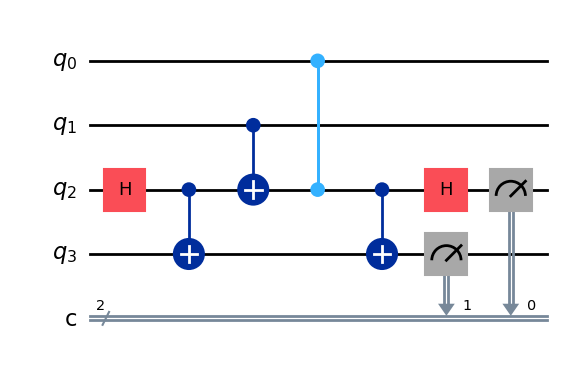

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi

def mermin_circuit():
    qreg_q = QuantumRegister(4, 'q')
    creg_c = ClassicalRegister(2, 'c')
    circuit = QuantumCircuit(qreg_q, creg_c)

    circuit.h(qreg_q[2])
    circuit.cx(qreg_q[2], qreg_q[3])
    circuit.cx(qreg_q[1], qreg_q[2])
    circuit.cz(qreg_q[0], qreg_q[2])
    circuit.cx(qreg_q[2], qreg_q[3])
    circuit.h(qreg_q[2])
    circuit.measure(qreg_q[3], creg_c[1])
    circuit.measure(qreg_q[2], creg_c[0])
    return circuit

qc = mermin_circuit()
qc.draw("mpl")


And evaluating its outputs for all 4 input combinations

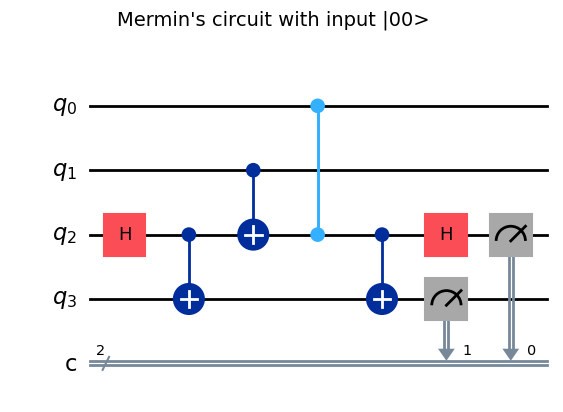

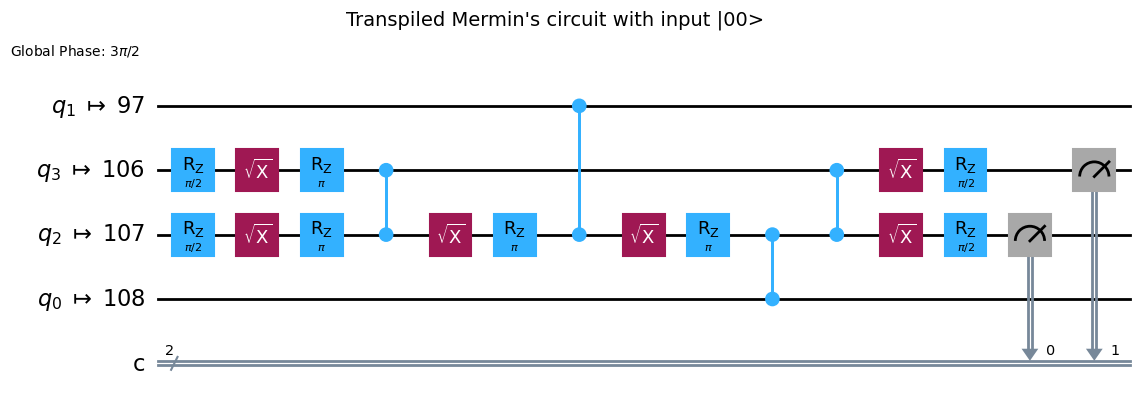

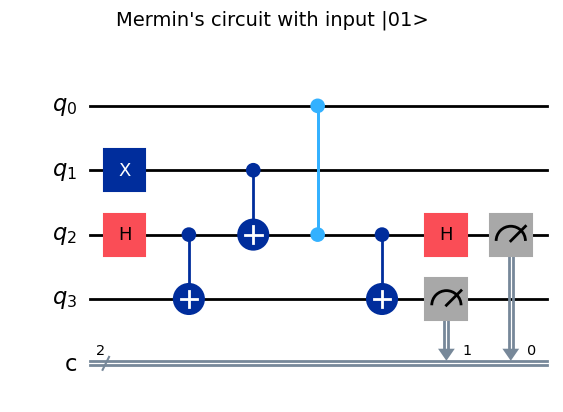

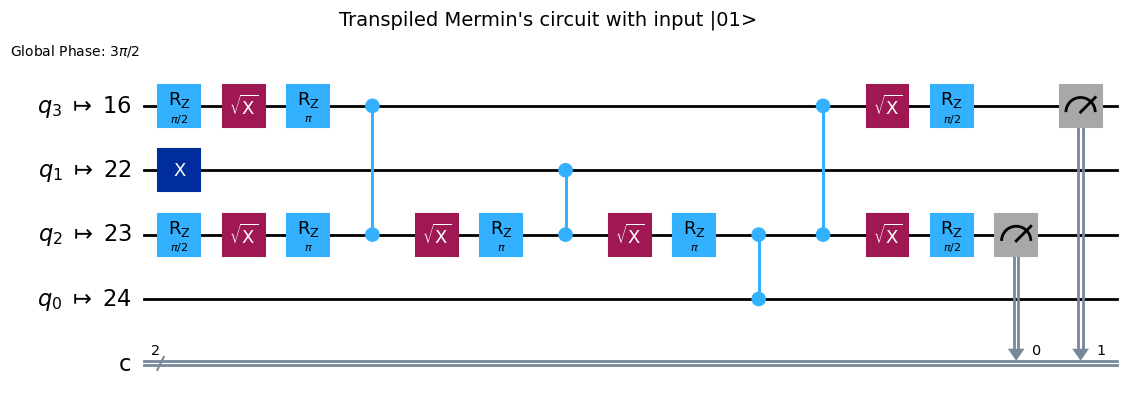

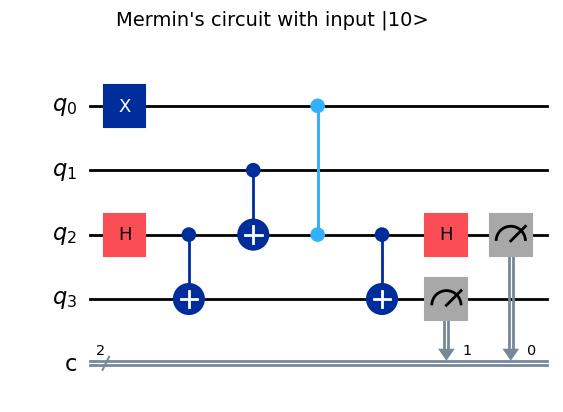

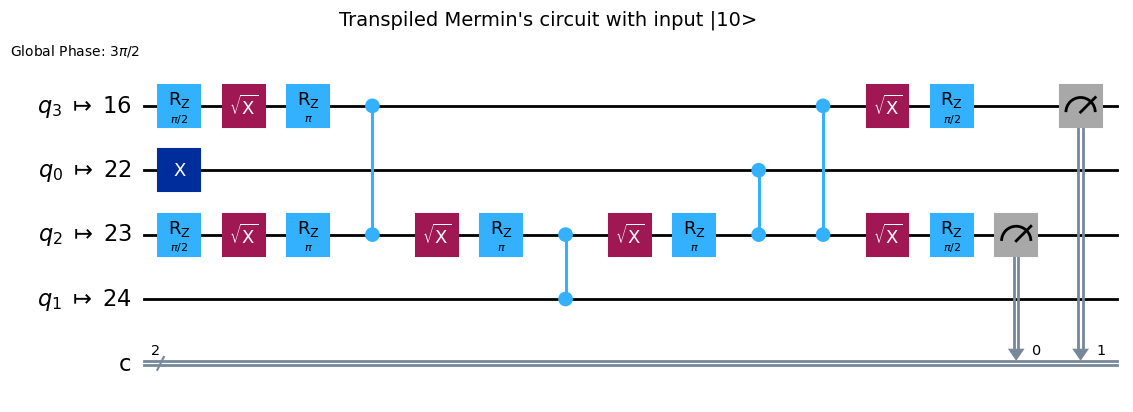

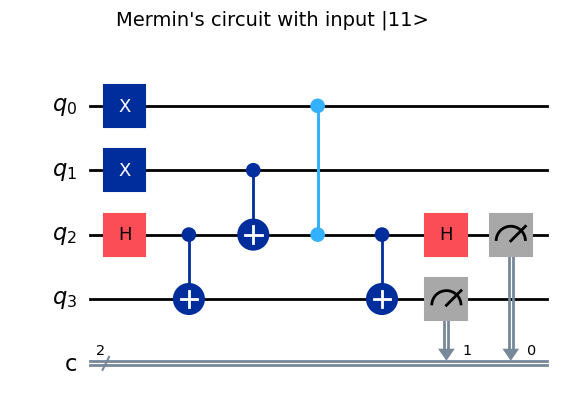

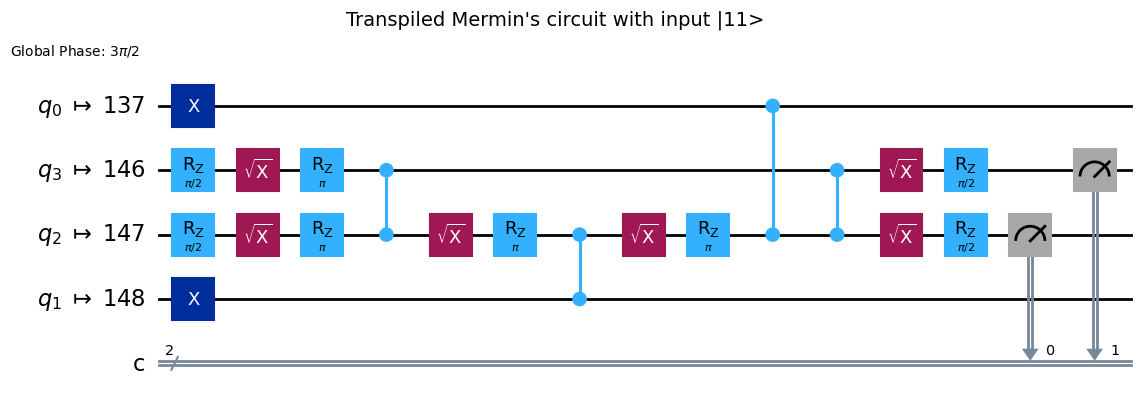

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit.visualization import plot_histogram
from qiskit import transpile
import matplotlib.pyplot as plt
from collections import Counter

API_KEY = "[YOUR_API_KEY]"

# Save account once (only needed the first time)
# QiskitRuntimeService.save_account(
#     channel='ibm_quantum_platform',
#     instance='crn:v1:bluemix:public:quantum-computing:us-east:a/e37b870a3a92417eb2e03e10c1326b8c:f0946229-5fda-4879-949e-af5843fdd081::',
#     token=API_KEY,
#     overwrite=True)

# Load service
service = QiskitRuntimeService()

backend = service.backend("ibm_fez")   

# Prepare the four input states
def prepare_input_state(base_circuit,input_bits):
    # Create a new circuit with same qubits and classical bits
    prep = QuantumCircuit(base_circuit.num_qubits, base_circuit.num_clbits)

    # Apply X gates to prepare |input_bits>
    for i, bit in enumerate(input_bits):
        if bit == '1':
            prep.x(i)

    # Append the original circuit after preparation
    qc = prep.compose(base_circuit)
    return qc

#if False:
# Iterate over all 4 inputs
inputs = ["00", "01", "10", "11"]
job_ids = {}

for inp in inputs:
    qc = mermin_circuit()
    qc = prepare_input_state(qc, inp)
    # Transpile
    qc_t = transpile(qc, backend)
    # Run
    sampler = SamplerV2(mode=backend)
    # Submit to IBM Quantum backend
    job = sampler.run([qc_t], shots=1024)
    job_ids[inp]= job.job_id()
    fig_c = qc.draw("mpl")   # matplotlib output
    fig_c.suptitle(f"Mermin's circuit with input |{inp}>", fontsize=14)
    fig_tc = qc_t.draw("mpl")   # matplotlib output
    fig_tc.suptitle(f"Transpiled Mermin's circuit with input |{inp}>", fontsize=14)

After executing Mermin's circuit for each input on IBM Quantum platform (using 'ibm_torino') we get the following results:

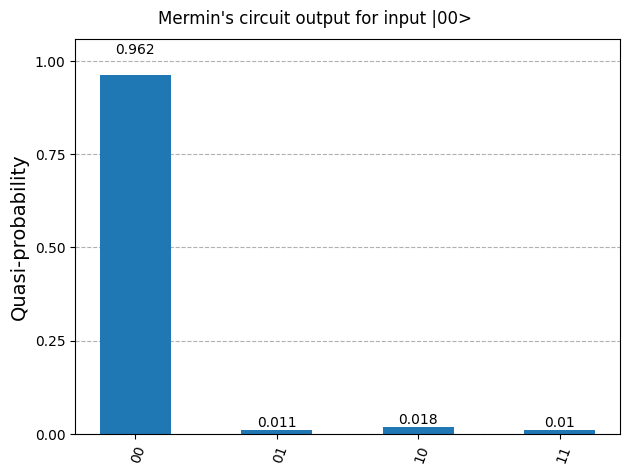

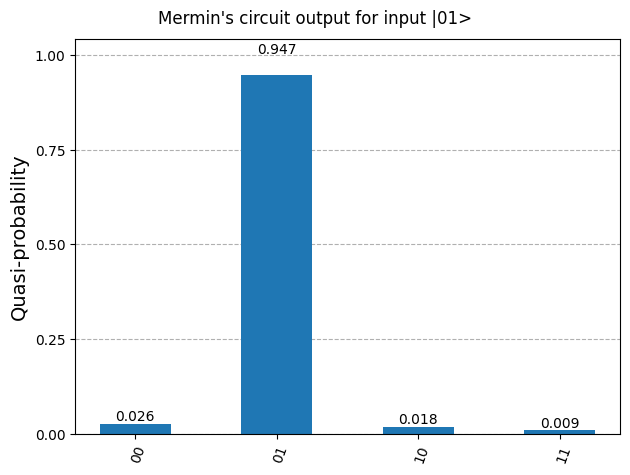

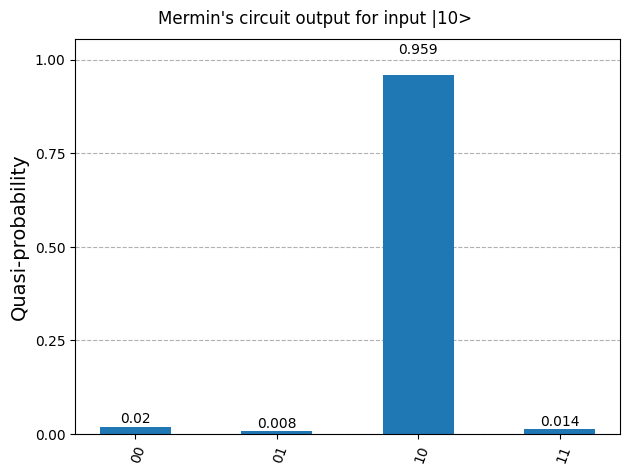

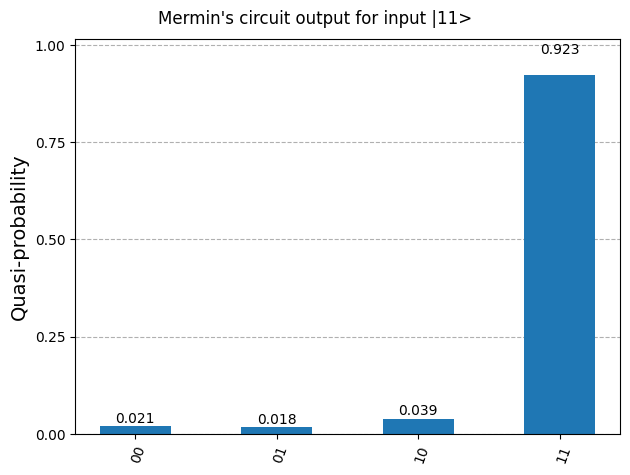

In [9]:
import numpy as np
%matplotlib inline

def display_job_result(job_result):
    # Each pub result is in result[0], result[1], ...
    pub_result = job_result[0]   # first circuit

    bitarray = pub_result.data.c # classical register 'c'

    # Access the underlying numpy array
    arr = bitarray.array  # dtype=uint8, shape=(num_shots, num_bytes)

    num_shots = bitarray.num_shots
    num_bits = bitarray.num_bits

    # Convert each shot to a bitstring
    samples = []
    for shot in arr:
        # shot is packed into bytes, so unpack bits
        bits = np.unpackbits(shot, bitorder="little")[:num_bits]
        samples.append("".join(str(b) for b in bits))

    # Count occurrences
    counts = Counter(samples)

    # Normalize to probabilities
    total_shots = sum(counts.values())
    probabilities = {state: freq/total_shots for state, freq in counts.items()}
    # Plot
    fig = plot_histogram(probabilities)
    return fig

for inp in inputs:   
    job = service.job(job_ids[inp])
    fig = display_job_result(job.result())
    fig.tight_layout(rect=[0, 0, 1, 0.95])  # reserve top 5% for suptitle
    fig.suptitle(f"Mermin's circuit output for input |{inp}>")

